### Fig input range (Fig 3)
- Summarize results of depletion test on 0.5 ng - 5 ug input RNA

In [1]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0)

sys.path.append('../scripts/')
from plot_helpers import *
import analyze_qpcr_plate

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Make outdir and load the data
outdir = '../figures/F3/'
os.makedirs(outdir, exist_ok = True)

In [3]:
qpcr_dir = os.path.join(results_dir, 'qPCR_data')

#0.5 ng to 1 ug input tests
low_input_data = ['200708_restest_100ng/20200708_125901_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx',
                  '200710_retest_100ng_2/20200710_153721_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx',
                  '200714_fly_titrate_repeat/20200714_132125_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx']

low_input_template = ['200708_restest_100ng/qPCR_analysis_template_restest_100ng.xlsx', 
                       '200710_retest_100ng_2/qPCR_analysis_template_retest2_100ng.xlsx',
                       '200714_fly_titrate_repeat/qPCR_analysis_template_flytitrate_repeat.xlsx']


#5 ug input in 40 ul rxn -- this served as the pre-sequencing QC as well.
hi_input_data = ['prep_1_190911/20190911_151311_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx', 
                  'prep_2_3_190912/20190912_122407_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx']

hi_input_template = ['prep_1_190911/qPCR_analysis_template_prep1.xlsx',
                      'prep_2_3_190912/qPCR_analysis_template_prep2_3.xlsx']

exps = {'data': [os.path.join(qpcr_dir, i) for i in low_input_data] + [os.path.join(qpcr_dir, i) for i in hi_input_data],
       'templates': [os.path.join(qpcr_dir, i) for i in low_input_template] + [os.path.join(qpcr_dir, i) for i in hi_input_template]}

df_list = []
for i in range(0, len(exps['data'])):
    df_list.append(analyze_qpcr_plate.main(exps['data'][i], exps['templates'][i], 'act5c'))
df = pd.concat(df_list)

In [4]:
#get relevant subset of samples:
these_samples = ['0.5ng_r1', '0.5ng_r2', '0.5ng_r3', '100ng_r1', '100ng_r2', '100ng_r3', '1ug_r1', '1ug_r2', '1ug_r3',
                 'PD_5ug_r1', 'PD_5ug_r2', 'PD_5ug_r3']
sum_df = df.loc[pd.IndexSlice[['18S', '28L', '28R'],:, these_samples],].droplevel('denominator').copy()
sum_df['input'], sum_df['rep'] = zip(*sum_df.index.get_level_values('sample').map(lambda x: x.rsplit('_', 1)))
sum_df['percent_remaining'] = sum_df['fold_change']*100

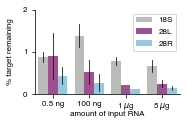

In [5]:
#Fig 3: plot the percent remaining at different input levels:
#https://stackoverflow.com/questions/5735208/remove-the-legend-on-a-matplotlib-figure
panel_name = '3'
plot = Plotter(corners = [0.16, 0.24, 0.84, 0.71], figsize = (sfig*1.5, sfig))
plot.nudge_corners(left = True, right = True)
plot.setup_axis()
plot.ax = sns.barplot(x="input", y="percent_remaining", order = ['0.5ng', '100ng', '1ug', 'PD_5ug'], hue="primer", data = sum_df.reset_index(), 
                      ci = 'sd', ax = plot.ax)
plot.set_ylabel('% target remaining')
plot.set_xlabel('amount of input RNA')
##plot.add_letter('A')
plot.ax.set_xticklabels(['0.5 ng', '100 ng', r'1 $\mu$g', r'5 $\mu$g'])
plot.ax.set_ylim(0, 2)
plt.legend(loc = 'best', ncol = 1, fontsize = label_fontsize)

#leg = plot.ax.get_legend().set_visible(False)
plot.ax.yaxis.set_major_locator(loc)
#seaborn is not respecting rcparams for linewidth, so change it here:
lines = plot.ax.lines
for line in lines:
    line.set_linewidth(0.75)
    line.set_color('k')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [6]:
#Report the mean % remaining for each input amount
sum_df.groupby(['input', 'primer'])['percent_remaining'].mean()

input   primer
0.5ng   18S       0.874861
        28L       0.901496
        28R       0.434894
100ng   18S       1.375325
        28L       0.517386
        28R       0.272671
1ug     18S       0.786650
        28L       0.210476
        28R       0.114256
PD_5ug  18S       0.669514
        28L       0.247320
        28R       0.140421
Name: percent_remaining, dtype: float64